In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import os
import unicodedata
import numpy as np
import folium

# configure config
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

# some read functions
def read(config_str):
    return pd.read_csv(resolve_path(config[config_str]))

def geo_read(config_str):
    return gpd.read_file(resolve_path(config[config_str]))

In [2]:
def normalize_text(text):
    return ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
    ).lower()

In [3]:
# a dictionary for countries in regions of Africa
african_countries = {
    "North Africa": [
        "Algeria", "Egypt", "Libya", "Morocco", "Sudan", "Tunisia", "Western Sahara"
    ],
    "South Africa": [
        "Botswana", "Eswatini", "Lesotho", "Namibia", "South Africa", "Zambia", "Zimbabwe"
    ],
    "East Africa": [
        "Burundi", "Comoros", "Djibouti", "Eritrea", "Ethiopia", "Kenya", "Madagascar", 
        "Malawi", "Mauritius", "Mayotte", "Mozambique", "Reunion", "Rwanda", "Seychelles", 
        "Somalia", "Tanzania", "Uganda"
    ],
    "West Africa": [
        "Benin", "Burkina Faso", "Cabo Verde", "CÃ´te d'Ivoire", "Gambia", "Ghana", 
        "Guinea", "Guinea-Bissau", "Liberia", "Mali", "Mauritania", "Niger", "Nigeria", 
        "Senegal", "Sierra Leone", "Togo"
    ],
    "Central Africa": [
        "Angola", "Cameroon", "Central African Republic", "Chad", "Congo", 
        "Equatorial Guinea", "Gabon", "Republic of Congo", "Sao Tome and Principe"
    ]
}


North Africa: CPIS have decreased by 7.58%
North Africa: Total irrigation area has increased by 50.26%
South Africa: CPIS have increased by 189.92%
South Africa: Total irrigation area has increased by 51.45%
East Africa: CPIS have increased by 282.69%
East Africa: Total irrigation area has increased by 79.53%
West Africa: CPIS have increased by 245.90%
West Africa: Total irrigation area has increased by 26.21%


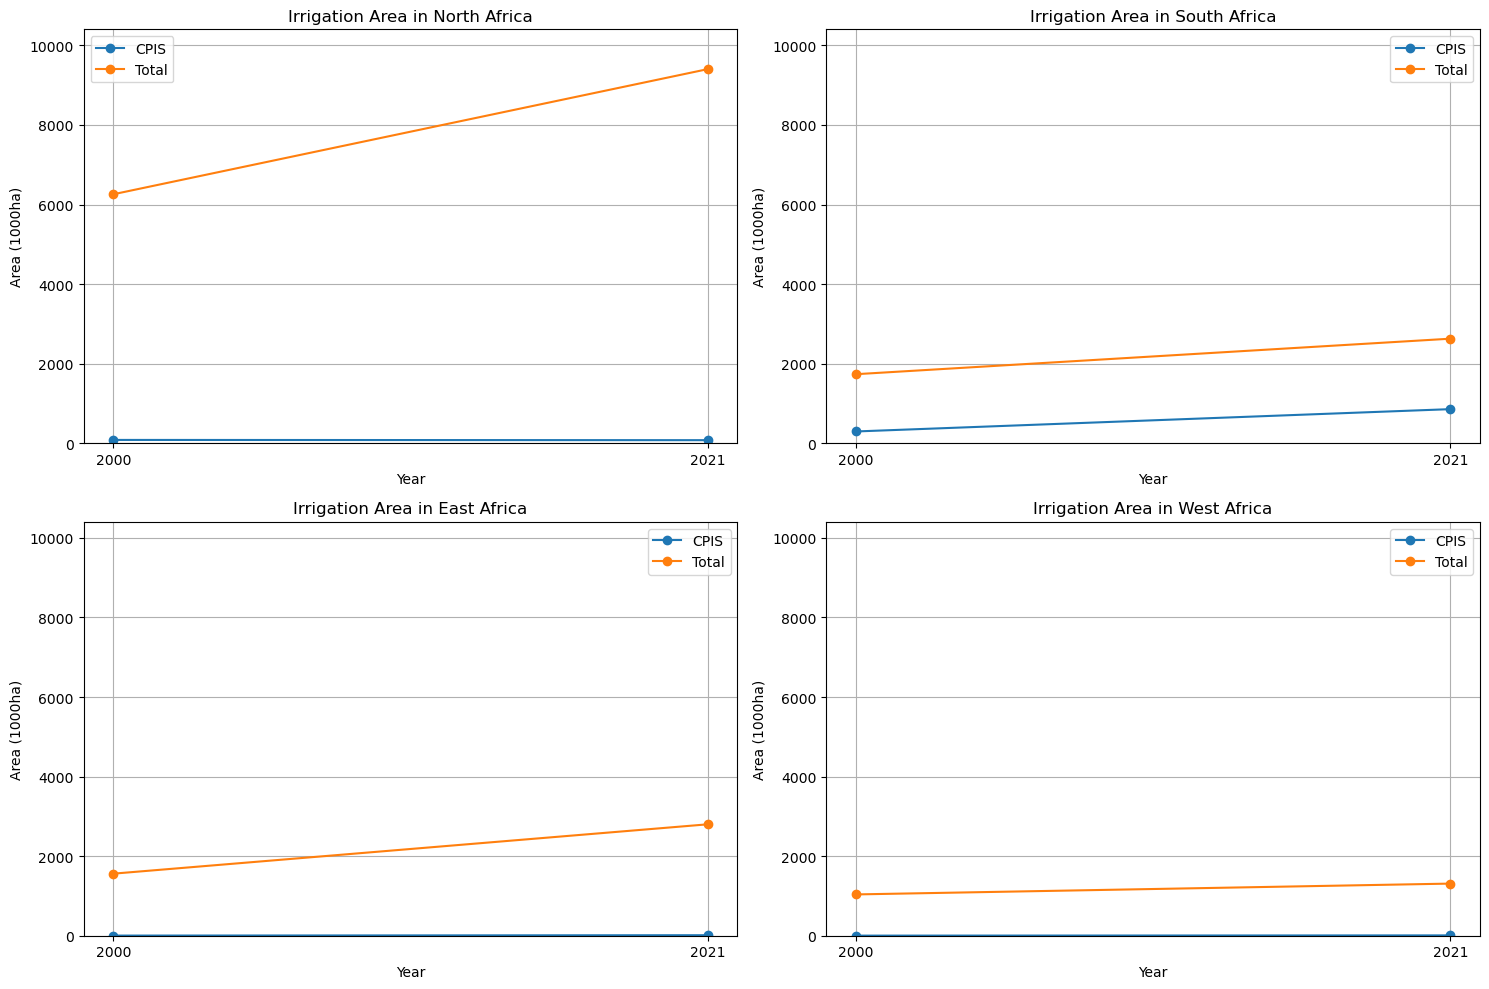

In [7]:
CPIS_area_2000 = read('CPIS_Area_by_Country_2000_path')
CPIS_area_2021 = read('CPIS_Area_by_Country_2021_path')

total_area_2000 = read('AQUA_AfricaIrrigation_2000')
total_area_2021 = read('AQUA_AfricaIrrigation_2021')

# Initialize a dictionary to store the sorted data
grouped_data = {region: {'CPIS_2000': 0, 'CPIS_2021': 0, 'total_2000': 0, 'total_2021': 0} for region in african_countries}

# Group and sum the data and add it to the dictionary
for region, countries in african_countries.items():
    CPIS_regional_2000 = CPIS_area_2000[CPIS_area_2000['Country'].isin(countries)]
    CPIS_regional_2021 = CPIS_area_2021[CPIS_area_2021['Country'].isin(countries)]
    total_regional_2000 = total_area_2000[total_area_2000['Area'].isin(countries)]
    total_regional_2021 = total_area_2021[total_area_2021['Area'].isin(countries)]

    grouped_data[region]['CPIS_2000'] = CPIS_regional_2000['Area_1000ha'].sum()
    grouped_data[region]['CPIS_2021'] = CPIS_regional_2021['Area_1000ha'].sum()
    grouped_data[region]['total_2000'] = total_regional_2000['Value'].sum()
    grouped_data[region]['total_2021'] = total_regional_2021['Value'].sum()

regions = ["North Africa", "South Africa", "East Africa", "West Africa"]

# Calculate the percent increase for each region
for region in regions:
    grouped_data[region]['percent_increase_CPIS'] = 100 * (grouped_data[region]['CPIS_2021'] - grouped_data[region]['CPIS_2000']) / grouped_data[region]['CPIS_2000']
    grouped_data[region]['percent_increase_total'] = 100 * (grouped_data[region]['total_2021'] - grouped_data[region]['total_2000']) / grouped_data[region]['total_2000']

# Print the results
for region in regions:
    percent_increase_CPIS = grouped_data[region]['percent_increase_CPIS']
    percent_increase_total = grouped_data[region]['percent_increase_total']
    if percent_increase_CPIS < 0:
        print(f'{region}: CPIS have decreased by {abs(percent_increase_CPIS):.2f}%')
    else:
        print(f'{region}: CPIS have increased by {percent_increase_CPIS:.2f}%')
    if percent_increase_total < 0:
        print(f'{region}: Total irrigation area has decreased by {abs(percent_increase_total):.2f}%')
    else:
        print(f'{region}: Total irrigation area has increased by {percent_increase_total:.2f}%')

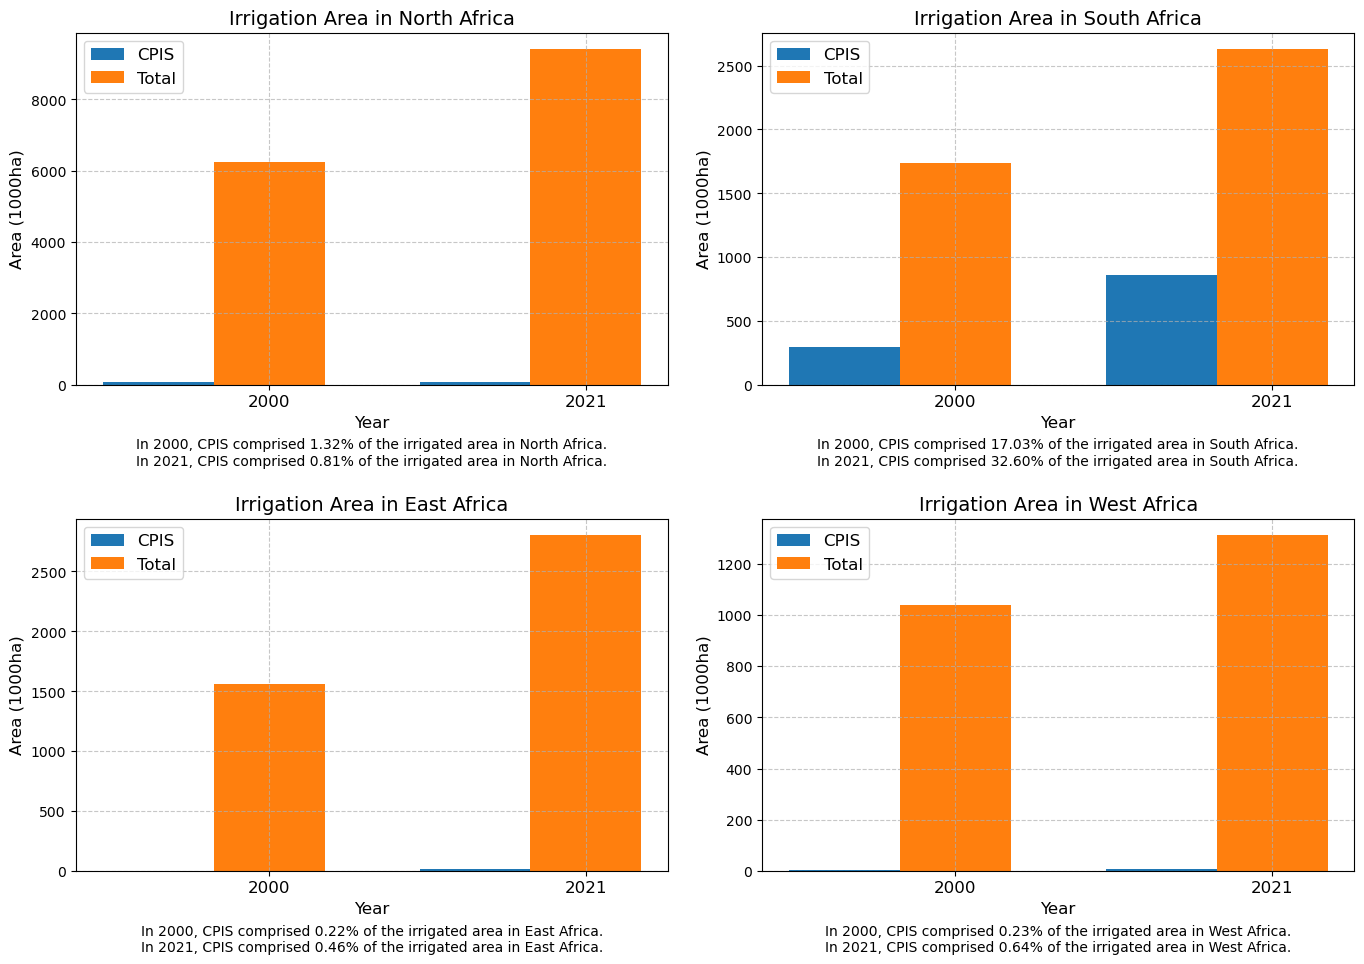

In [9]:
# Initialize dictionary to hold the percentages for each year
ratios = {region: {'2000': 0, '2021': 0} for region in african_countries}

# Calculate the percentages per region
for region in african_countries:
        ratios[region]['2000'] = (grouped_data[region]['CPIS_2000'] / grouped_data[region]['total_2000']) * 100
        ratios[region]['2021'] = (grouped_data[region]['CPIS_2021'] / grouped_data[region]['total_2021']) * 100

# Set up and plot each graph
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
bar_width = 0.35
bar_spacing = 0.1
colors = ['#1f77b4', '#ff7f0e']
regions = ["North Africa", "South Africa", "East Africa", "West Africa"]

for i, region in enumerate(regions):
    ax = axs[i // 2, i % 2]
    index = [0, 1]
    CPIS_values = [grouped_data[region]['CPIS_2000'], grouped_data[region]['CPIS_2021']]
    total_values = [grouped_data[region]['total_2000'], grouped_data[region]['total_2021']]
    
    ax.bar([x - bar_width for x in index], CPIS_values, bar_width, label='CPIS', color=colors[0])
    ax.bar([x for x in index], total_values, bar_width, label='Total', color=colors[1])
    
    ax.set_title(f'Irrigation Area in {region}', fontsize=14)
    ax.set_ylabel('Area (1000ha)', fontsize=12)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_xticks([x for x in index])
    ax.set_xticklabels(['2000', '2021'], fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

    # Format the text under each graph
    ratio_2000 = f"In 2000, CPIS comprised {ratios[region]['2000']:.2f}% of the irrigated area in {region}."
    ratio_2021 = f"In 2021, CPIS comprised {ratios[region]['2021']:.2f}% of the irrigated area in {region}."
    text_y = -0.15  # Adjust this value as needed
    ax.text(0.5, text_y, f"{ratio_2000}\n{ratio_2021}",
            ha='center', va='top', transform=ax.transAxes, fontsize=10)

# Pad to avoid overlap with the text    
plt.tight_layout(pad=2)
plt.show()